# Reproducible Genomic Interpretation Tools for Translational Medicine: Application to An N of 1 Case Study 


#### Author: C. Mazzaferro & K. Fisch
#### Email: Kfisch@ucsd.edu
#### Date: June 2016

## Description
Translational medicine leverages genomic data to discover targeted therapeutics and new diagnostic tools. To apply genomics to translational medicine, there exists a need for open source, collaborative, and reproducible computational tools that integrate multi-omics data and interpret these findings into clinically actionable results.  A plethora of tools and algorithms exist for primary and secondary analyses of next generation sequencing data. However, reproducible tools for biological interpretation and integration of these data are lacking.  

To enable reproducible genomic interpretation for translational medicine, we have developed a collection of open source Jupyter notebooks authored by staff at the UCSD Center for Computational Biology for performing network analyses, next generation sequencing analyses using Omics Pipe on Amazon Web Services and custom pipelines for integrated data analysis for precision medicine.  These pipelines are fully executable on a Jupyter notebook server hosted on AWS (public AMI: ami3ba14b5b).  Static notebooks are hosted on GitHub (https://github.com/ucsd-ccbb/jupyter-genomics).  These notebooks provide a customizable graphical user interface along with documentation to aid in the biological interpretation of the analysis results.  These notebooks depend upon analysis modules that we have exposed to the user, so custom genomic interpretation pipelines can easily be created and shared.

As a case study, we have applied this framework to create a molecular profile of uveal melanoma for neoantigen discovery in an N-of-1 study. Germline whole genome sequencing (WGS), tumor RNA sequencing (RNAseq) and targeted tumor sequencing data were analyzed, integrated and interpreted. We calculated relative gene expression, detected transcribed, germline and somatic mutations, determined HLA types and expression, and predicted mutant epitopes. All raw data were aligned to the human genome (hg19), variants were called using the GATK best practices for DNA and RNA, gene expression was quantified using RSEM, and normalized with DESEQ2. TCGA UVM RNAseqV2 raw count data were used as a reference cohort for gene expression. Genes from the DecisionDX-UM gene panel from the patient and TCGA were clustered using hierarchical clustering for subtype discovery. Variants from all datasets were overlaid in Integrative Genomics Viewer (IGV) to identify somatic mutations with high confidence. HLA types and expression were calculated with seq2HLA. Mutant epitopes were predicted using Varcode and MHC binding prediction was performed with NetMHCcons.  The N of 1 design of this study provided an interesting perspective on data interpretation and visualization and provided the patient and clinicians with a genomic profile of the tumor. This study highlights the need for reproducible, open-source biological interpretation tools, such as Jupyter-Genomics, to further translational medicine. We hope to enhance transparency and reproducibility of next generation sequencing analysis and biological interpretation, which will be needed for translating this technology into routine clinical practice.



## Table of Contents
<a id = "toc"></a>
1. <a href = "#background">Background</a>
2. <a href = "#data">Read in Annotated VCF files</a>
3. <a href = "#prioritize">Prioritize Variants</a>
    * <a href = "#tumorRNA">Tumor RNA Variants</a>
    * <a href = "#tumorDNA">Tumor DNA Variants</a>
    * <a href = "#normalDNA">Matched normal DNA Variants</a>
    * <a href = "#bloodWGS">Blood WGS germline Variants</a>
4. <a href = "#visualize">Visualize Variants of Interest</a>
5. <a href = "#hla">HLA subtyping</a>
6. <a href = "#epitopes">Mutant Epitopes</a>
7. <a href = "#MHC">MHC Binding Prediction</a>
8. <a href = "#network">Network Analysis</a>
9. <a href = "#gene_exp">N of 1 Gene Expression Relative to TCGA</a>
10. <a href = "#subtype">Subtype Stratification</a>

<a id = "background"></a>
## Background

Data from whole genome sequencing from blood, targeted sequencing from tumor and matched normal and RNA sequencing from tumor were provided to CCBB for analysis of a patient with UVM. 

Goals of the analysis are:

1. Characterize molecular landscape of the patient’s tumor

2. Identify prognostic markers

3. Identify tumor neoantigens for immunotherapy


In [ ]:
#Import modules
import sys 
import os
import time
import datetime 
import numpy as np
import csv
from IPython.display import IFrame
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, precision=4)
from IPython.display import HTML
import mygene
import myvariant
import collections
import re

mv = myvariant.MyVariantInfo()
import sys
#sys.path.append('/root/anaconda3/lib/python3.5/site-packages')
import vcf

In [ ]:
import pysam

<a id = "data"></a>
## Read in Annotated VCF files
Annovar processing of VCF files in order to extract information from specifc databases. See the [documentation](http://annovar.openbioinformatics.org/en/latest/) for information on how to obtain the required databases. Output is in .csv format, which will be parsed into pandas for filtering. 

In [ ]:
!sudo perl /database/annovar/table_annovar.pl /root/BIOM262/Tumor_targeted_seq.vcf /database/annovar/humandb -buildver hg19 -out /root/BIOM262/Tumor_targeted_seq -remove -protocol knownGene,tfbsConsSites,cytoBand,targetScanS,genomicSuperDups,gwasCatalog,esp6500siv2_all,1000g2014oct_all,snp138,ljb26_all,cg46,cg69,popfreq_all,clinvar_20160302,cosmic70,nci60 -operation g,r,r,r,r,r,f,f,f,f,f,f,f,f,f,f -nastring . -csvout -vcfinput

In [ ]:
!sudo perl /database/annovar/table_annovar.pl /root/BIOM262/Normal_targeted_seq.vcf /database/annovar/humandb -buildver hg19 -out /root/BIOM262/Normal_targeted_seq -remove -protocol knownGene,tfbsConsSites,cytoBand,targetScanS,genomicSuperDups,gwasCatalog,esp6500siv2_all,1000g2014oct_all,snp138,ljb26_all,cg46,cg69,popfreq_all,clinvar_20160302,cosmic70,nci60 -operation g,r,r,r,r,r,f,f,f,f,f,f,f,f,f,f -nastring . -csvout -vcfinput

In [ ]:
!sudo perl /database/annovar/table_annovar.pl /root/BIOM262/Tumor_RNAseq_variants.vcf /database/annovar/humandb -buildver hg19 -out /root/BIOM262/Tumor_RNAseq_variants -remove -protocol knownGene,tfbsConsSites,cytoBand,targetScanS,genomicSuperDups,gwasCatalog,esp6500siv2_all,1000g2014oct_all,snp138,ljb26_all,cg46,cg69,popfreq_all,clinvar_20160302,cosmic70,nci60 -operation g,r,r,r,r,r,f,f,f,f,f,f,f,f,f,f -nastring . -csvout -vcfinput

In [ ]:
!sudo perl /database/annovar/table_annovar.pl /data/Nof1/somatic_mutect_old.vcf /database/annovar/humandb -buildver hg19 -out /data/Nof1/somatic_mutect_old_annotated -remove -protocol knownGene,tfbsConsSites,cytoBand,targetScanS,genomicSuperDups,gwasCatalog,esp6500si_all,1000g2014oct_all,snp138,ljb26_all,cg46,cg69,popfreq_all,clinvar_20140929,cosmic70,nci60 -operation g,r,r,r,r,r,f,f,f,f,f,f,f,f,f,f -nastring . -csvout -vcfinput

## Definition of general purpose functions

In [ ]:
# Remove header rows from csv files
def remove_header(sample_name):
    
    #creates a new file with no header
    with open(sample_name + ".hg19_multianno.csv", "rb") as infile, open(sample_name + ".hg19_multianno_noheader.csv", "wb") as outfile:
        reader = csv.reader(infile)
        #header = next(reader)  
        writer = csv.writer(outfile)
        for row in reader:
            if row[0][0] != '#':
                writer.writerow(row)
                
# Parse into Pandas 
def parse_to_pandas(sample_name):
    listoflists = []
    with open(sample_name+".hg19_multianno_noheader.csv", 'rb') as csvfile:
        reader = csv.reader(csvfile)
        header = next(reader) 
        for row in reader:
            listoflists.append(row)
            
    variants = pd.DataFrame(listoflists, columns=header)
    return variants

def modify_df(df):
    df = df.replace(".",np.nan)
    cols = df.columns
    cols = cols.map(lambda df: df.replace('.', '_') if isinstance(df, (str, unicode)) else df)
    df.columns = cols
    df = df.rename(columns={'1000g2014oct_all': 'ThousandGenomeAll'})
    return df

def filter_df(df):
    
    #convert to float for filtering by value
    df[['PopFreqMax', 'esp6500siv2_all','nci60','ThousandGenomeAll','DP' ]] = df[['PopFreqMax', 'esp6500siv2_all','nci60', 'ThousandGenomeAll', 'DP']].astype(float)
    
    #Filter for rare variants
    filter1 = df.query('ThousandGenomeAll < 0.05 or ThousandGenomeAll != ThousandGenomeAll', engine ='python')
    filter2 = filter1.query('esp6500siv2_all != esp6500siv2_all or esp6500siv2_all < 0.05 or cosmic70 == cosmic70', engine ='python')
    filter3 = filter2.query('Func_knownGene == "exonic" or Func_knownGene == "exonic;splicing" or Func_knownGene == "splicing"', engine ='python')
    filter4 = filter3.query('ExonicFunc_knownGene != "synonymous SNV"',engine ='python')
    return filter4


def filter_DP(df):
    
    #filter for higher Depth (>10)
    filtered_DP = df.query('DP > 10', engine = 'python')
    return filtered_DP

def extract_DP(df):
   
    #Depth informations resides in the OtherInfo Column and needs to be parsed out
    string = df.Otherinfo.split()[-3]
    splitted = re.findall(r'[^,;]+', string)
    matching = [s for s in splitted if "DP" in s]
    values = matching[0].split('=')
    return values[1]

def write_csv_out(df, sample_name):
    df.to_csv(sample_name + "_rare_variants_V2.csv")
    
def reject_or_keep(df):
    
    #if a file was manually inspected and its information analyzed, it may contain a 'REJECT' or 'KEEP' string info 
    #in the Otherinfo column
    string = df.Otherinfo.split()[-5]
    return string

In [ ]:
#Change directory to location of annotated csv files from annovar
os.chdir("/data/Nof1")

<a id = "prioritize"></a>
# Prioritize variants
Apply functions in order to find the rare variants within the dataframes. 

In [ ]:
samples = ["Tumor_RNAseq_variants", "Tumor_targeted_seq", "Normal_targeted_seq", "normal_blood_wgs_hli_B1000000012_S1.vqsr_annotated", "somatic_mutect_old_annotated"]

<a id = "tumorRNA"></a>
## Tumor RNA variants

In [ ]:
sample = samples[0]

remove_header(sample)
df = parse_to_pandas(sample)
df['DP'] = df.apply(extract_DP, axis=1)
modified = modify_df(df)
filtered_tumor_RNA_variants = filter_df(modified)
filtered_tumor_RNA_variants = filter_DP(filtered_tumor_RNA_variants)
filtered_tumor_RNA_variants.head(10)

In [ ]:
len(filtered_tumor_RNA_variants)

In [ ]:
write_csv_out(filtered_tumor_RNA_variants, sample)

<a id = "tumorDNA"></a>
## Tumor DNA variants

In [ ]:
sample = samples[1]

remove_header(sample)
df = parse_to_pandas(sample)
df['DP'] = df.apply(extract_DP, axis=1)
modified = modify_df(df)
filtered_tumor_DNA_variants = filter_df(modified)
filtered_tumor_DNA_variants = filter_DP(filtered_tumor_DNA_variants)
filtered_tumor_DNA_variants.head(10)

In [ ]:
len(filtered_tumor_DNA_variants)

In [ ]:
write_csv_out(filtered_tumor_DNA_variants, sample)

<a id = "normalDNA"></a>
## Matched normal DNA variants

In [ ]:
sample = samples[2]

remove_header(sample)
df = parse_to_pandas(sample)
df['DP'] = df.apply(extract_DP, axis=1)
modified = modify_df(df)
filtered_normal_DNA_variants = filter_df(modified)
filtered_normal_DNA_variants = filter_DP(filtered_normal_DNA_variants)
filtered_normal_DNA_variants.head(10)

In [ ]:
len(filtered_normal_DNA_variants)

In [ ]:
write_csv_out(filtered_tumor_RNA_variants, sample)

<a id = "bloodWGS"></a>
## Blood WGS germline variants

In [ ]:
tp = pd.read_csv(samples[3]+".hg19_multianno.txt", sep='\t', iterator=True, chunksize=1000)  # gives TextFileReader, which is iterable with chunks of 1000 rows.
df = pd.concat(tp, ignore_index=True) 

In [ ]:
modified = modify_df(df)
modified['DP'] = pd.Series(np.nan)

In [ ]:
filtered_normal_blood_variants = filter_df(modified)
filtered_normal_blood_variants.head(10)

In [ ]:
write_csv_out(filtered_normal_blood_variants, samples[3])

In [ ]:
len(filtered_normal_blood_variants)

## Somatic Mutect Data
Data came from the application of [MuTect](https://www.broadinstitute.org/cancer/cga/mutect)

In [ ]:
sample = samples[4]
remove_header(sample)
df = parse_to_pandas(sample)
df['Rej_Keep'] = df.apply(reject_or_keep, axis=1)
modified = modify_df(df)
somatic_mutect_variants = modified.query('Rej_Keep != "REJECT"')
somatic_mutect_variants.head(10)

In [ ]:
len(somatic_mutect_variants)

In [ ]:
write_csv_out(somatic_mutect_variants, sample)

<a id = "visualize"></a>
## Visualize variants of interest

#Possible things to do: 

In [ ]:
from IPython.core.display import display, HTML
display(HTML('http://e84.ensembl.org/Homo_sapiens/Location/View?r=9:77794589-77794599;db=core'))

<a id = "hla"></a>
## HLA subtyping
###RNAseq
#seq2HLA

<a id = "epitopes"></a>
## Mutant epitopes
Using varcode to predict the peptide sequences affected by the filtered, rare variants. In order to plug into varcode only the variants of interest, we will have to generate a filtered vcf file from the pandas dataframes we had before. This will be done with the help of pyvcf.


In [ ]:
import varcode
from varcode import load_maf, load_vcf
from varcode import Insertion
from pyensembl import ensembl_grch37
import vcf

In [ ]:
#Provided a dataframe, file input and output paths, this function wil create a vcf file that contains information
#only in the positions specified in the dataframe. Since it has been filtered, the output file will be a subset of
#the original file. The original file is required as well in order to serve as base structure for the creation of
#a new vcf file. 

def generate_filtered_vcf(df, vcf_input_path, vcf_output_path):
    
    sliced_df = df[['Chr', 'Start']]
    
    chr_vars = list(sliced_df.Chr.values)
    location_vars_ant = map(int,list(sliced_df.Start.values))
    location_vars_pos = map(int,list(sliced_df.Start.values))

    location_vars_ant = map(lambda x:x+1, location_vars_ant)
    location_vars_pos = map(lambda x:x-1, location_vars_pos)
    
    vcf_reader = vcf.Reader(filename = vcf_input_path)
    vcf_writer = vcf.Writer(open(vcf_output_path, 'w'), vcf_reader)

    for i in range(0, len(chr_vars)):
        for record in vcf_reader.fetch(chr_vars[i],location_vars_pos[i],location_vars_ant[i]):
            vcf_writer.write_record(record)
    

## List of dataframes and their matched original vcf file. 

The output, filtered vcf file will be name [dataframe_name]_VCF

- filtered_tumor_RNA_variants       ->       Tumor_RNAseq_variants.vcf.gz
- filtered_tumor_DNA_variants       ->      Tumor_targeted_seq.vcf.gz
- filtered_normal_DNA_variants      ->       Normal_targeted_seq.vcf.gz
- filtered_normal_blood_variants    ->       normal_blood_WGS.vqsr.vcf.gz  
- somatic_mutect_variants           ->       somatic_mutect_old.vcf.gz  

In [ ]:
#Generate index file for each file
os.chdir('/data/Nof1/')
!tabix Tumor_RNAseq_variants.vcf.gz
!tabix Tumor_targeted_seq.vcf.gz
!tabix Normal_targeted_seq.vcf.gz
!tabix normal_blood_WGS.vqsr.vcf.gz
!tabix somatic_mutect_old.vcf.gz

Generate smaller sample vcf files to be used in varcode

In [ ]:
generate_filtered_vcf(filtered_tumor_RNA_variants, 'Tumor_RNAseq_variants.vcf.gz','filtered_tumor_RNA_variants.vcf')
generate_filtered_vcf(filtered_tumor_DNA_variants, 'Tumor_targeted_seq.vcf.gz','filtered_tumor_DNA_variants.vcf')
generate_filtered_vcf(filtered_normal_DNA_variants, 'Normal_targeted_seq.vcf.gz','filtered_normal_DNA_variants.vcf')
generate_filtered_vcf(filtered_normal_blood_variants , 'normal_blood_WGS.vqsr.vcf.gz','filtered_normal_blood_variants.vcf')
generate_filtered_vcf(somatic_mutect_variants, 'somatic_mutect_old.vcf.gz','somatic_mutect_variants.vcf'  )

## General useful functions to manipulate the data coming from varcode

In [ ]:
def variants_to_list(vcfVariants):
    listoflists = []
    error_variants = []

    for i in range(0, len(vcfVariants)):
        try:
            listoflists.append(vcfVariants[i].effects())
        except:
            error_variants.append(i)
    for i in error_variants:
        del listoflists[i]
        
    return listoflists

def get_non_silent_variants(variant_list):
    
    #Mark variants that are silent and non-coding. They will replace the variants in the list created
    #in the function before with an empty list, and will be removed using the next function
    non_coding =[]
    non_coding_silent =[]
    
    for i in range(0,len(variant_list)):
        non_coding.append(variant_list[i].drop_silent_and_noncoding()) 
        non_coding_silent.append(non_coding[i].elements)
        
    return non_coding_silent

def remove_empty_variants(variant_list):
    #Remove empty
    non_empty = [x for x in variant_list if x != []]
    #Flatten list
    flattened_list = [item for sublist in non_empty for item in sublist]
    return flattened_list

def get_protein_list(variant_list):
    
    #Varcode's method variant.mutant_protein_sequence will output the proteins affected by it.
    list_of_proteins = []
    for i in range(0, len(variant_list)):
        list_of_proteins.append(str(variant_list[i].mutant_protein_sequence))
    
    return list_of_proteins

def get_variant_name(filtered_variants):
    
    #Getting each variant's name to be placed as a header line for the protein sequence. This will yield a FASTA-
    #formatted file that will be analyzed using MHCconsSites
    variant_name = []
    for i in range(0, len(filtered_variants)):
        variant_i = re.split("[=,]+", str(filtered_variants[i]))[1]
        variant_i = variant_i.replace(" ",":")
        variant_i = variant_i.replace(">","~")
        variant_i = '>' + variant_i
        variant_name.append(variant_i)
        
    return variant_name

def rem_duplicates(protein_list, variant_list):
    
    #Remove duplicate variants/proteins 
    df = pd.DataFrame({'variants' : variant_list, 'prot': protein_list})
    df = df.drop_duplicates(subset = 'variants')
    df = df.drop_duplicates(subset = 'prot')
    return df

## load all variant files 

In [ ]:
READER_filtered_RNA_turmor = load_vcf("/data/Nof1/filtered_tumor_RNA_variants.vcf")
READER_filtered_DNA_tumor = load_vcf("/data/Nof1/filtered_tumor_DNA_variants.vcf")
READER_filtered_DNA_normal = load_vcf("/data/Nof1/filtered_normal_DNA_variants.vcf")
READER_filtered_blood_normal = load_vcf("/data/Nof1/filtered_normal_blood_variants.vcf")
READER_somatic_mutect = load_vcf("/data/Nof1/somatic_mutect_variants.vcf")

## RNA Tumor Variants - Peptide Sequence

In [ ]:
primary_variants = variants_to_list(READER_filtered_RNA_turmor)
filtered_variants = get_non_silent_variants(primary_variants)
filtered_variants = remove_empty_variants(filtered_variants)
protein_list = get_protein_list(filtered_variants)
var_name = get_variant_name(filtered_variants)


In [ ]:
unique_prot = rem_duplicates(protein_list, var_name)
unique_prot_list = list(unique_prot.prot.values)
unique_var_name  = list(unique_prot.variants.values)
len(unique_var_name)

In [ ]:
with open('/data/Nof1/TransMed_data/Peptides_RNA.txt', 'w') as outfile:
    for i in range(0, len(unique_var_name)):
        outfile.write(unique_var_name[i] + "\n" + unique_prot_list[i] + "\n")
outfile.close()

## Tumor Variants - Peptide sequence

In [ ]:
primary_variants = variants_to_list(READER_filtered_DNA_tumor)
filtered_variants = get_non_silent_variants(primary_variants)
filtered_variants = remove_empty_variants(filtered_variants)
protein_list = get_protein_list(filtered_variants)
var_name = get_variant_name(filtered_variants)
unique_prot = rem_duplicates(protein_list, var_name)

In [ ]:
unique_prot = rem_duplicates(protein_list, var_name)
unique_prot_list = list(unique_prot.prot.values)
unique_var_name  = list(unique_prot.variants.values)
len(unique_var_name)

In [ ]:
#Write output file in FASTA format
with open('/data/Nof1/TransMed_data/Peptides_DNA.txt', 'w') as outfile:
    for i in range(0, len(unique_var_name)):
        outfile.write(unique_var_name[i] + "\n" + unique_prot_list[i] + "\n")
outfile.close()

## Mutect Variants - Peptide Sequence

In [ ]:
primary_variants = variants_to_list(READER_somatic_mutect)
filtered_variants = get_non_silent_variants(primary_variants)
filtered_variants = remove_empty_variants(filtered_variants)
protein_list = get_protein_list(filtered_variants)
var_name = get_variant_name(filtered_variants)

In [ ]:
with open('/data/Nof1/TransMed_data/Peptides_Mutect.txt', 'w') as outfile:
    for i in range(0, len(var_name)):
        outfile.write(var_name[i] + "\n" + protein_list[i] + "\n")
outfile.close()


<a id = "MHC"></a>
## MHC binding prediction
#NetMHCcons

Through antigen processing, proteins produced within a cell are degraded into short peptides, usually of 8–11 residues in length that may then be loaded on MHC-I molecules and presented on the cell surface. In this way, cytotoxic T lymphocytes are capable of recognizing the infected cells and triggering an immune response. Thousands of different allelic versions of MHC molecules exist, making complete experimental characterization of peptide–MHC interactions highly cost-intensive [[1]](http://link.springer.com/article/10.1007%2Fs00251-011-0579-8).

After the peptide sequences are retrieved, they can be analyzed using NetMHCcons. It can be done through their website, or using a command line argument. This service is aimed at allowing users to obtain accurate binding predictions of MHC in an automated manner. 

In [ ]:
from IPython.core.display import display, HTML
display(HTML('http://www.cbs.dtu.dk/services/NetMHCcons/'))

 ## Some analysis of MHC binding predictions


Use Alleles: HLA-A02:01,HLA-B07:02,HLA-C07:02,HLA-C14:02,HLA-B51:01,HLA-A03:01
Use file: Peptides_RNA

# Switch to R kernel

<a id = "gene_exp"></a>
## Calculate Relative Gene Expression from TCGA

<a id = "subtype"></a>

## DecisionDx subtype stratification

In [ ]:
#Created by K. Fisch 9/16/15
library(mygene)
library(DESeq2)
require(RColorBrewer)
require(cluster)
library(gplots)
library(ggplot2)
source("/data/Nof1/RNA_seq_DE.R")


setwd("/data/Nof1")
TCGA_genes <- read.csv("UVM.rnaseqv2_raw_counts.csv",stringsAsFactors=FALSE)
patient_genes_rsem <- read.csv("Uveal.genes.results", sep="\t", stringsAsFactors=FALSE)

genes <- unlist(patient_genes_rsem$gene_id)
gene.entrez <- queryMany(genes, scopes="ensembl.gene", species="human")
entrez.df <- gene.entrez[,c("entrezgene","symbol", "query")]
genes.annot <- merge(patient_genes_rsem,entrez.df, by.x="gene_id", by.y="query", all.x=TRUE, all.y=FALSE)
write.csv(genes.annot,"patient_genes_rsem_annotated.csv")

patient_TCGA <-merge(TCGA_genes, genes.annot, by.x="ENTREZ", by.y="entrezgene", all=F)
write.csv(patient_TCGA, "patient_genes_UVM_TCGA.csv")

patient_TCGA_edit <- read.csv("patient_genes_UVM_TCGA_edited2.csv", stringsAsFactors=FALSE)

geneCount <- patient_TCGA_edit[,c(4:84)]
#row.names(geneCount) <-patient_TCGA_edit$ENTREZ
geneCount <- round(geneCount)
row.names(geneCount) <-patient_TCGA_edit$SYMBOL
df <- geneCount
# preprocess data
group <- factor(rep(c('TCGA', "patient"), c(80,1)))

# trs length (only needed for rpkm values)
trsLength <- NA
if(is.element("length", colnames(df)))
  trsLength <- df[rc > 0,"length"]

# normalization using deseq
norm <- getNormData(df, group, trsLength, addRaw=TRUE)
deseq <- log2(norm$DESeq+1)
sf_deseq <- getSizeFactor(df, group)$DESeq # save the size factors of the ref cohort
write.csv(deseq, "patient_TCGA_normalized_deseq_annotated.csv")

###############################################################################
# Analysis
###############################################################################

# nonspecic Filtering
sds <- apply(deseq,1,sd)
use <- (sds > quantile(sds, 0.50))
deseqNsf <- deseq[use,]

useHeat <- (sds > quantile(sds, 0.95))
deseqHeat <- deseq[useHeat,]

# heatmap
heatmap.2(deseqHeat, 
          Rowv=TRUE, 
          #Colv=hc, 
          col=greenred(75), 
          scale="row", 
          #ColSideColors=unlist(sapply(group, mycol)), 
          trace="none", 
          key=TRUE,
          cexRow=0.25,
          cexCol=0.25
)


In [2]:
heatUVM <- deseq[c('152100','23451','23532','999','11031','4893', '673',
                   '4609','50807','595','596',
                   '1029','5728','8314','11186'), ]

ERROR: Error in deseq[c("152100", "23451", "23532", "999", "11031", "4893", "673", : subscript out of bounds


In [3]:
head(deseq)

,TCGA.RZ.AB0B.01A.11R.A405.07,TCGA.V3.A9ZX.01A.11R.A405.07,TCGA.V3.A9ZY.01A.11R.A405.07,TCGA.V4.A9E5.01A.11R.A405.07,TCGA.V4.A9E7.01A.11R.A405.07,TCGA.V4.A9E8.01A.11R.A405.07,TCGA.V4.A9E9.01A.11R.A405.07,TCGA.V4.A9EA.01A.11R.A405.07,TCGA.V4.A9EC.01A.11R.A405.07,TCGA.V4.A9ED.01A.11R.A405.07,⋯,TCGA.WC.A888.01A.11R.A405.07,TCGA.WC.A88A.01A.11R.A405.07,TCGA.WC.AA9A.01A.11R.A405.07,TCGA.WC.AA9E.01A.11R.A405.07,TCGA.YZ.A980.01A.11R.A405.07,TCGA.YZ.A982.01A.11R.A405.07,TCGA.YZ.A983.01A.11R.A405.07,TCGA.YZ.A984.01A.11R.A405.07,TCGA.YZ.A985.01A.11R.A405.07,Karin_rsem_count
AGAP4,8.03523091225315,7.11292370072747,6.84912875513741,5.19833498700126,6.91577414917168,5.75578080291953,5.96883883985643,5.42199461244259,6.75238025062021,7.23796570061989,⋯,8.5658858165347,6.26769342518431,9.11006754622372,8.27153737098867,8.00018344930127,6.68798901018279,8.66601381796355,6.58723912486791,6.44690181264137,7.93645125102426
ARL17A,5.63388924449899,5.97076669348116,5.2077575850057,5.13598960925432,6.66934105415104,6.46150198151176,6.45251215141914,5.99569644744768,6.17409304433406,5.52914832087865,⋯,6.1005884800439,5.71185319075904,5.76623277570849,6.17878470970238,6.47297652950686,6.89861561715083,7.14700757007252,5.92861367968242,6.61498816893966,10.242081741087
BAZ2B,9.98603903167768,9.64981456003681,7.9885705479728,7.63091617163513,8.95399345732648,7.87016960042397,7.68958964388406,7.54543606933965,8.54118041012655,8.77282507567382,⋯,9.43401346448369,8.57456359005646,9.93557667907015,9.22276104699,9.64724307081726,8.36636272141792,9.51205810224214,8.5625565399281,8.48740584064923,5.89608754316497
C10orf68,3.14530305949634,3.07141024821995,0,0,0,1.53309067611815,0,0,0,1.95744358491989,⋯,3.41416427879464,0,3.56433681393183,3.38348814973457,2.29382938525614,1.38997164507926,2.25640774947561,0,1.6580861122456,0
CALM2,13.4775138772552,13.2002073000516,12.5256645688339,12.0998090610404,13.0405963743165,12.7962757097757,12.4794791643973,11.3148079031811,12.5285014873858,12.5978432793526,⋯,12.7728540112555,13.2472474302921,13.3990781154872,12.4568990716517,13.3559924087205,12.544338930568,13.0225597606637,12.6090695288676,12.1530518619333,14.9170074549823
CBWD1,10.1069784665866,9.17658162233609,8.33109827586715,8.75202684941497,9.23529504362388,9.02228500985682,9.30377865801991,8.61080901361316,8.36272167792097,8.84998627840129,⋯,8.79101541171799,9.53358902912816,9.65722687945908,10.7118619858225,9.61528804669486,8.6251195101316,9.97974927158311,8.87562584582231,9.27557755607351,9.98855421603461


In [13]:
deseq_df <- as.data.frame(deseq)
heatUVM <- deseq[c("CMC1","SF3B1","PRAME","CDH1","NRAS","BRAF","MYC","ASAP1","CCND1","BCL2",
                        "CDKN2A","PTEN","BAP1","RASSF1"),]
head(heatUVM) 

,TCGA.RZ.AB0B.01A.11R.A405.07,TCGA.V3.A9ZX.01A.11R.A405.07,TCGA.V3.A9ZY.01A.11R.A405.07,TCGA.V4.A9E5.01A.11R.A405.07,TCGA.V4.A9E7.01A.11R.A405.07,TCGA.V4.A9E8.01A.11R.A405.07,TCGA.V4.A9E9.01A.11R.A405.07,TCGA.V4.A9EA.01A.11R.A405.07,TCGA.V4.A9EC.01A.11R.A405.07,TCGA.V4.A9ED.01A.11R.A405.07,⋯,TCGA.WC.A888.01A.11R.A405.07,TCGA.WC.A88A.01A.11R.A405.07,TCGA.WC.AA9A.01A.11R.A405.07,TCGA.WC.AA9E.01A.11R.A405.07,TCGA.YZ.A980.01A.11R.A405.07,TCGA.YZ.A982.01A.11R.A405.07,TCGA.YZ.A983.01A.11R.A405.07,TCGA.YZ.A984.01A.11R.A405.07,TCGA.YZ.A985.01A.11R.A405.07,Karin_rsem_count
CMC1,7.65750576618403,7.73118943630773,7.90601343526254,7.34427996651794,7.61895278960094,7.16041476421897,7.46836148502422,6.4915315758704,8.27892035281968,6.96578969164918,⋯,7.92903843125038,8.07026114809785,8.15348675086469,8.8305878940017,7.34870796942103,7.33496860261908,8.62863257706327,7.26959254755873,6.8215920872752,11.5351074298378
SF3B1,12.9246149374674,12.5941658227136,11.3989084886577,10.721925262363,12.207252745311,11.5440107320017,11.3539435293295,10.9161692421104,12.1977243379689,11.7511504990567,⋯,12.5059226458104,12.3841932067058,12.6909030813163,12.9079977752419,12.3948136106772,12.1898119387989,12.8767308226362,11.8434929771918,11.9023211919176,14.850892006897
PRAME,11.9740374129478,14.3144370640579,1.19166494785948,9.20723301007264,11.5106138040626,12.7350676955997,14.0188270304949,12.1556185500482,5.47067321811757,5.03214714254834,⋯,10.0678155916653,14.4358103307823,5.96273590487525,12.7714236202208,5.25110611242728,2.55144364033366,2.51664649259213,12.4285551984748,1.6580861122456,13.5928721536944
CDH1,14.7889852202484,13.1237961891165,13.632841416514,7.46331192246343,14.4333365746115,15.0055804828789,13.4305243052684,10.1836023790807,11.1067995807389,15.0159880170912,⋯,14.4811143553674,14.5123921795999,13.8153111049662,10.866732928341,14.8128764296348,13.7767359905914,13.0522200144137,15.2424562176361,16.0793214519767,14.100557014815
NRAS,9.98603903167768,10.7447396900562,9.33747353206989,9.56757447475095,8.99124469269592,9.60982380742623,9.24218606390271,8.80901815329398,9.36392206067189,9.45084904397672,⋯,9.83778181034755,10.449965054507,8.99024611976754,10.0181042035493,9.57031553416467,9.64681651404074,10.2180436203402,9.35862675475512,9.69128762142881,9.43852151472572
BRAF,7.54075424350743,7.17995398507867,6.94246038500414,7.00377225063449,7.34563242599527,6.43015687040993,6.15860175333847,6.5731027099788,7.4460639975518,6.92071600216849,⋯,6.1005884800439,7.55798656285687,6.56768326630282,7.68103190829927,7.31373706795465,6.7326463030235,7.36105445132748,5.84263042808842,7.22653093288237,11.2180367915844


In [ ]:
#heatUVM <- deseq[c('152100','23451','23532','999','11031','4893', '673',
#                   '4609','50807','595','596',
#                   '1029','5728','8314','11186'), ]
#heatUVM <- deseq[c("CMC1","SF3B1","PRAME","CDH1","RAB311","NRAS","BRAF","MYC","ASAP1","CCND1","BCL2",
#                        "CDKN2A","PTEN","BAP1","RASSF1"),]
#head(heatUVM)                 
#row.names(heatUVM) <- c("CMC1","SF3B1","PRAME","CDH1","RAB311","NRAS","BRAF","MYC","ASAP1","CCND1","BCL2",
#                        "CDKN2A","PTEN","BAP1","RASSF1")

heatmap.2(heatUVM, 
          Rowv=TRUE, 
          #Colv=hc, 
          col=greenred(75), 
          scale="row", 
          #ColSideColors=unlist(sapply(group, mycol)), 
          trace="none", 
          key=TRUE,
          cexRow=0.7,
          cexCol=0.25
)


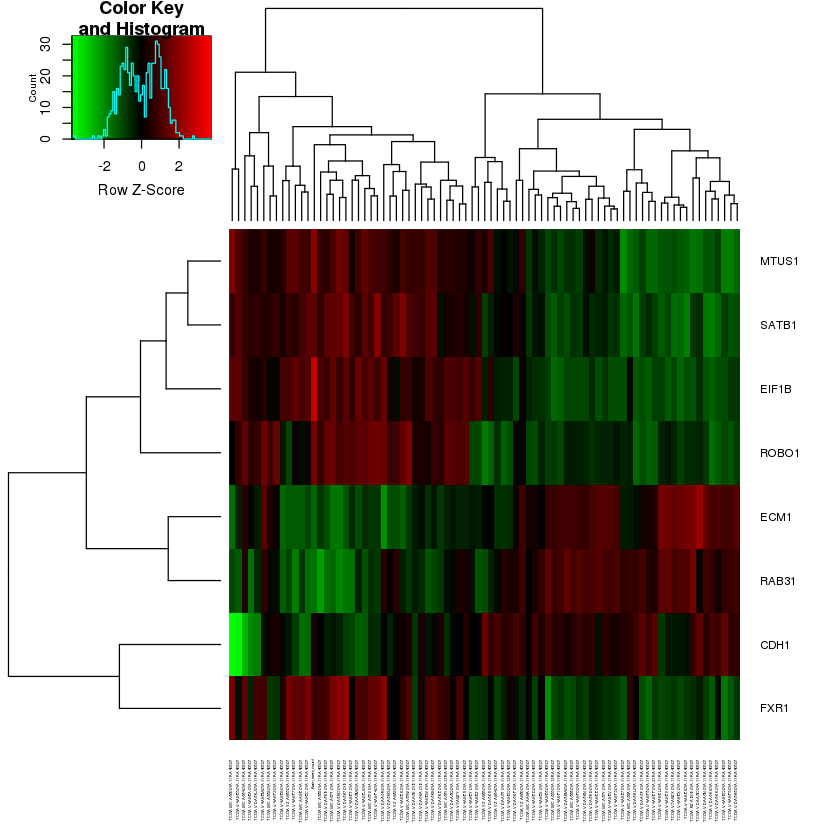

In [18]:
##DecisionDX-UM Panel Genes
heatUVM2 <- deseq[c("MTUS1","SATB1", "EIF1B", "CDH1", "ROBO1", "ECM1", "RAB31", "FXR1"),]
heatmap.2(heatUVM2, 
          Rowv=TRUE, 
          #Colv=hc, 
          col=greenred(75), 
          scale="row", 
          #ColSideColors=unlist(sapply(group, mycol)), 
          trace="none", 
          key=TRUE,
          cexRow=0.7,
          cexCol=0.25
)
